# Scraping

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

import pandas as pd
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--disable-images")  # Disable images
edge_options.add_argument("--disable-javascript")  # Disable JavaScript
edge_options.add_argument("--disable-plugins")  # Disable plugins
edge_options.add_argument("--disable-extensions")  # Disable extensions
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

driver = webdriver.Edge(options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


driver.maximize_window()

driver.execute_script("document.body.style.zoom='67%'")

In [ ]:
driver.get('https://www.olympedia.org/athletes/advanced_search')

In [ ]:
sport_codes={e.get_attribute('value'):e.text for e in driver.find_elements(By.CSS_SELECTOR, 'select[name="sport_group"][id="sport_select"] option') if e.text!=''}

In [ ]:
sport_athletes={}

for i, (sport_code, sport) in enumerate(sport_codes.items(),start=1):
    all_athletes=[]
    for page in range(1,10001):
        url=f'https://www.olympedia.org/athletes/search_athlete?affiliations=&bio=&birthcountry=&birthplace=&competition_type_id=&continent=&country=&date%5Bbirthday%5D=&date%5Bbirthmonth%5D=&date%5Bbirthyear%5D=&date%5Bdeathday%5D=&date%5Bdeathmonth%5D=&date%5Bdeathyear%5D=&deathcountry=&deathplace=&event_name=&gender=&given_name=&id=&image=&medal=&page={page}&second_country=&sport=&sport_group={sport_code}&surname=&year2=&year='
        html=requests.get(url,headers).content
        soup=BeautifulSoup(html,'html.parser')
        athletes=['https://www.olympedia.org'+e['href'] for e in soup.select('table[class="x"] x x x') if 'athletes' in e['href']]
        if len(athletes)==0:
            break
        all_athletes.extend(athletes)
        
        print(f'Sport: {i}/{len(sport_codes)}, Page: {page}, Total: {len(all_athletes)}'.ljust(80), end='\r')
    
    sport_athletes[sport]=all_athletes
    


In [2]:
#pickle.dump(sport_athletes, open('sport_athletes.pickle','wb'))
sport_athletes=pickle.load( open('sport_athletes.pickle','rb'))

In [7]:
total = len([url for sublist in sport_athletes.values() for url in sublist])
total

181059

In [4]:
sorted_files=sorted(os.listdir('scraped_athletes'), key=lambda x: (int(x.split('_')[2]), int(x.split('_')[3].split('.pickle')[0])))

max_scraped={}
max_sport_index=0
for file in sorted_files:
    sport_index=int(file.split('_')[2])
    athlete_index=int(file.split('_')[3].split('.pickle')[0])
    max_scraped[sport_index]=athlete_index

    if sport_index>max_sport_index:
        max_sport_index=sport_index
print(max_scraped)
print(max_sport_index)

{1: 2239, 2: 46, 3: 820, 4: 16135, 5: 1374, 6: 86, 7: 27331, 8: 38, 9: 1252, 10: 5005, 11: 13, 17: 3602, 18: 36, 19: 80, 20: 10, 22: 6703, 23: 24, 24: 13, 25: 2605, 26: 10477, 27: 5196, 28: 66, 29: 12, 30: 10, 31: 474, 34: 5805, 35: 4084, 36: 5525, 37: 6265, 38: 239, 39: 20, 40: 3322, 41: 47, 42: 51, 43: 6, 44: 146, 46: 1046, 47: 10, 48: 190, 49: 36, 50: 23, 51: 1025, 52: 25, 53: 113, 54: 223, 55: 126, 56: 24, 57: 10, 58: 8705, 59: 4, 60: 242, 61: 1134, 62: 3000, 63: 1987, 64: 49, 65: 5309, 66: 5000}
66


In [ ]:
for i, (sport, athlete_urls) in enumerate(sport_athletes.items(),start=1):

    if i<max_sport_index:
        continue

    all_dicts=[]
    for j, athlete_url in enumerate(athlete_urls,start=1):
        
        if i in max_scraped:
            athlete_index= max_scraped[i]
            if j<=athlete_index:
                continue

        try:
            html=requests.get(athlete_url,headers).content
            soup=BeautifulSoup(html,'html.parser')

            bio_dict={e.th.text:e.td.text for e in soup.select('x[class="x"] x')}
            bio_dict['Sport']=sport
            bio_dict['URL']=athlete_url
            
            all_dicts.append(bio_dict)

        except:
            continue

        print(f'Sport: {i}/{len(sport_athletes)}, Athlete: {j}/{len(athlete_urls)}'.ljust(100),end='\r')

        if j%1000==0 or j==len(athlete_urls):
            pickle.dump(all_dicts, open(f'scraped_athletes/all_dicts_{i}_{j}.pickle','wb'))
            all_dicts=[]


# Cleaning

In [39]:
import pickle
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geopandas

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_data=[]

for file in os.listdir('scraped_athletes'):

    file_dir=os.path.join('scraped_athletes',file)
    data=pickle.load(open(file_dir,'rb'))
    all_data.extend(data)

In [3]:
df=pd.DataFrame(all_data)

In [4]:
df

,Roles,Sex,Full name,Used name,Original name,Born,NOC,Sport,URL,Affiliations,Measurements,Died,Nick/petnames,Other names,Nationality,Name order,Title(s)
0,Referee,Male,Samir•Abaakil,Samir•Abaakil,سمير•أباعقيل,"5 June 1970 in Taza, Fès-Meknès (MAR)",Morocco,BK - Basketball,https://www.olympedia.org/athletes/5004331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Competed in Olympic Games,Male,Alberto•Abalde Díaz,Alberto•Abalde,NaN,"15 December 1995 in Ferrol, La Coruña (ESP)",Spain,BK - Basketball,https://www.olympedia.org/athletes/142484,"Real Madrid, Madrid (ESP)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Competed in Olympic Games • Non-starter,Female,Tamara•Abalde Díaz,Tamara•Abalde,NaN,"6 February 1989 in Ferrol, La Coruña (ESP)",Spain,BK - Basketball,https://www.olympedia.org/athletes/111826,"Rivas Futura, ESP",185 cm / 72 kg,NaN,NaN,NaN,NaN,NaN,NaN
3,Competed in Olympic Games • Non-starter,Male,Youssef Mohamed•Abbas,Youssef•Abbas,يوسف محمد•عباس,"2 December 1920 in Abu Za'bal, Qalyubiyah (EGY)",Egypt,BK - Basketball,https://www.olympedia.org/athletes/5567,"Al-Ahly, Al-Qahira (EGY)",NaN,28 October 1956 in Mediterranean Sea (UNK),NaN,NaN,NaN,NaN,NaN
4,Competed in Olympic Games,Male,Alessandro•Abbio,Alessandro•Abbio,NaN,"13 March 1971 in Racconigi, Cuneo (ITA)",Italy,BK - Basketball,https://www.olympedia.org/athletes/82754,"Virtus Bologna, Bologna (ITA)",195 cm / 85 kg,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180723,Competed in Olympic Games,Male,Fidel•LaBarba,Fidel•LaBarba,NaN,"29 September 1905 in Bronx, New York (USA)",United States,BX - Boxing,https://www.olympedia.org/athletes/8710,"LAAC, Los Angeles (USA)",160 cm / 51 kg,"2 October 1981 in Los Angeles, California (USA)",NaN,NaN,NaN,NaN,NaN
180724,Competed in Olympic Games,Male,Ceferino Darío•Labarda,Ceferino•Labarda,NaN,"6 April 1981 in Luján de Cuyo, Mendoza (ARG)",Argentina,BX - Boxing,https://www.olympedia.org/athletes/90097,NaN,164 cm / 54 kg,NaN,El Pelado,NaN,NaN,NaN,NaN
180725,Referee,Male,Roland•Labbe,Roland•Labbe,NaN,NaN,Canada,BX - Boxing,https://www.olympedia.org/athletes/5004235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180726,Competed in Olympic Games,Male,Rabah•Labiod,Rabah•Labiod,رباح•الابيض,"26 March 1948 in Constantine, Constantine (ALG)",Algeria,BX - Boxing,https://www.olympedia.org/athletes/7438,NaN,173 cm / 67 kg,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df=df.drop_duplicates(subset=['Sport','URL'])

In [6]:
df=df.drop(columns=['Original name','Affiliations','Nick/petnames','Other names', 'Nationality', 'Name order', 'Title(s)'])

In [7]:
df_na_1=df.isna().mean()
df_na_1

Roles           0.000033
Sex             0.000033
Full name       0.000033
Used name       0.000033
Born            0.051099
NOC             0.000033
Sport           0.000000
URL             0.000000
Measurements    0.368056
Died            0.771839
dtype: float64

In [8]:
df['Born']=df['Born'].apply(lambda x:
                 x.strip().split('in')[0] if isinstance(x,str) and 'in' in str(x) else
                 ' '.join(x.split(' ')[:3]) if isinstance(x,str) and 'in' not in str(x) else x)
df['Born']=pd.to_datetime(df['Born'],format='mixed', errors='coerce')


df['Died']=df['Died'].apply(lambda x:
                 x.strip().split('in')[0] if isinstance(x,str) and 'in' in str(x) else
                 ' '.join(x.split(' ')[:3]) if isinstance(x,str) and 'in' not in str(x) else x)
df['Died']=pd.to_datetime(df['Died'],format='mixed', errors='coerce')

In [9]:
df['Height (cm)']=df['Measurements'].apply(lambda x:x.split('cm')[0].split('/')[-1] if isinstance(x,str) else None).apply(pd.to_numeric, errors='coerce')
df['Weight (kg)']=df['Measurements'].apply(lambda x:x.split('kg')[0].split('/')[-1] if isinstance(x,str) else None).apply(pd.to_numeric, errors='coerce')

df=df.drop(columns='Measurements')

In [10]:
df['Death Age']=((df['Died']-df['Born']).dt.days/365).round(2)

In [11]:
df_na_2=df.isna().mean()
df_na_2

Roles          0.000033
Sex            0.000033
Full name      0.000033
Used name      0.000033
Born           0.052975
NOC            0.000033
Sport          0.000000
URL            0.000000
Died           0.773372
Height (cm)    0.374967
Weight (kg)    0.400580
Death Age      0.774761
dtype: float64

In [12]:
change=df_na_2-df_na_1
change[change>0]

Born    0.001876
Died    0.001533
dtype: float64

In [13]:
df

,Roles,Sex,Full name,Used name,Born,NOC,Sport,URL,Died,Height (cm),Weight (kg),Death Age
0,Referee,Male,Samir•Abaakil,Samir•Abaakil,1970-06-05,Morocco,BK - Basketball,https://www.olympedia.org/athletes/5004331,NaT,NaN,NaN,NaN
1,Competed in Olympic Games,Male,Alberto•Abalde Díaz,Alberto•Abalde,1995-12-15,Spain,BK - Basketball,https://www.olympedia.org/athletes/142484,NaT,NaN,NaN,NaN
2,Competed in Olympic Games • Non-starter,Female,Tamara•Abalde Díaz,Tamara•Abalde,1989-02-06,Spain,BK - Basketball,https://www.olympedia.org/athletes/111826,NaT,185.0,72.0,NaN
3,Competed in Olympic Games • Non-starter,Male,Youssef Mohamed•Abbas,Youssef•Abbas,1920-12-02,Egypt,BK - Basketball,https://www.olympedia.org/athletes/5567,1956-10-28,NaN,NaN,35.93
4,Competed in Olympic Games,Male,Alessandro•Abbio,Alessandro•Abbio,1971-03-13,Italy,BK - Basketball,https://www.olympedia.org/athletes/82754,NaT,195.0,85.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
180723,Competed in Olympic Games,Male,Fidel•LaBarba,Fidel•LaBarba,1905-09-29,United States,BX - Boxing,https://www.olympedia.org/athletes/8710,1981-10-02,160.0,51.0,76.06
180724,Competed in Olympic Games,Male,Ceferino Darío•Labarda,Ceferino•Labarda,1981-04-06,Argentina,BX - Boxing,https://www.olympedia.org/athletes/90097,NaT,164.0,54.0,NaN
180725,Referee,Male,Roland•Labbe,Roland•Labbe,NaT,Canada,BX - Boxing,https://www.olympedia.org/athletes/5004235,NaT,NaN,NaN,NaN
180726,Competed in Olympic Games,Male,Rabah•Labiod,Rabah•Labiod,1948-03-26,Algeria,BX - Boxing,https://www.olympedia.org/athletes/7438,NaT,173.0,67.0,NaN


# Visaulizing Data

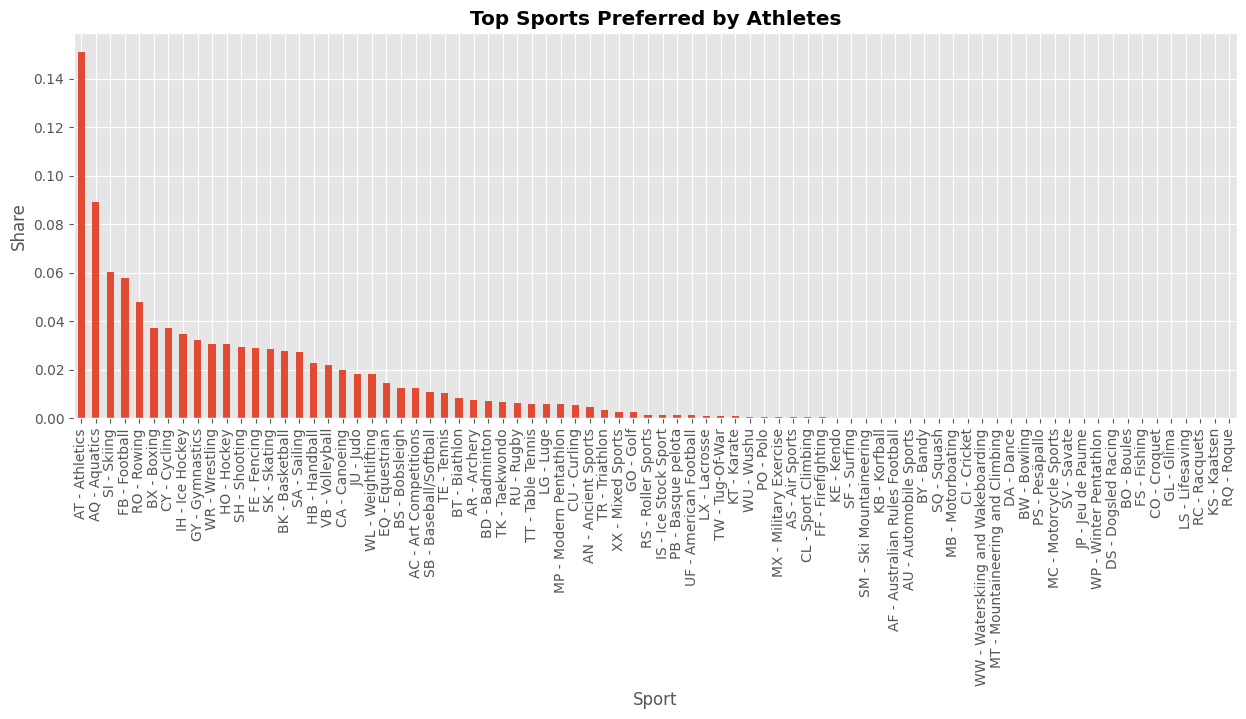

In [14]:
plt.figure(figsize=(15,5))
df['Sport'].value_counts(normalize=True).plot.bar()
plt.title('Top Sports Preferred by Athletes',fontweight='bold')
plt.ylabel('Share')
plt.show()

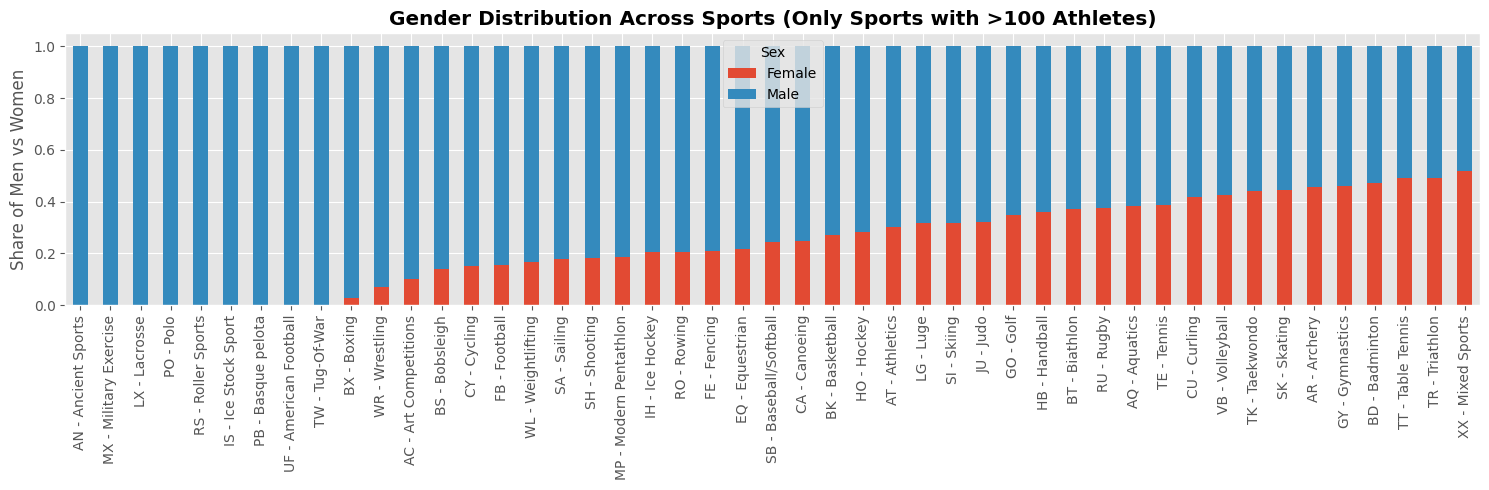

In [15]:
grouped=df.groupby(['Sport','Sex']).filter(lambda x:x['Full name'].count()>100)\
.groupby(['Sport','Sex'])['Full name'].count()\
.groupby(level=0).transform(lambda x:x/x.sum())\
.reset_index()
grouped=pd.pivot_table(grouped,index='Sport',columns='Sex',values='Full name')
grouped=grouped.fillna(0)
grouped=grouped.reset_index().sort_values('Female',ascending=True)


ax = grouped.plot(kind='bar', stacked=True, figsize=(15, 5))
ax.set_title("Gender Distribution Across Sports (Only Sports with >100 Athletes)", fontweight='bold')
ax.set_ylabel('Share of Men vs Women')
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped['Sport'], rotation=90)
plt.tight_layout()
plt.show()

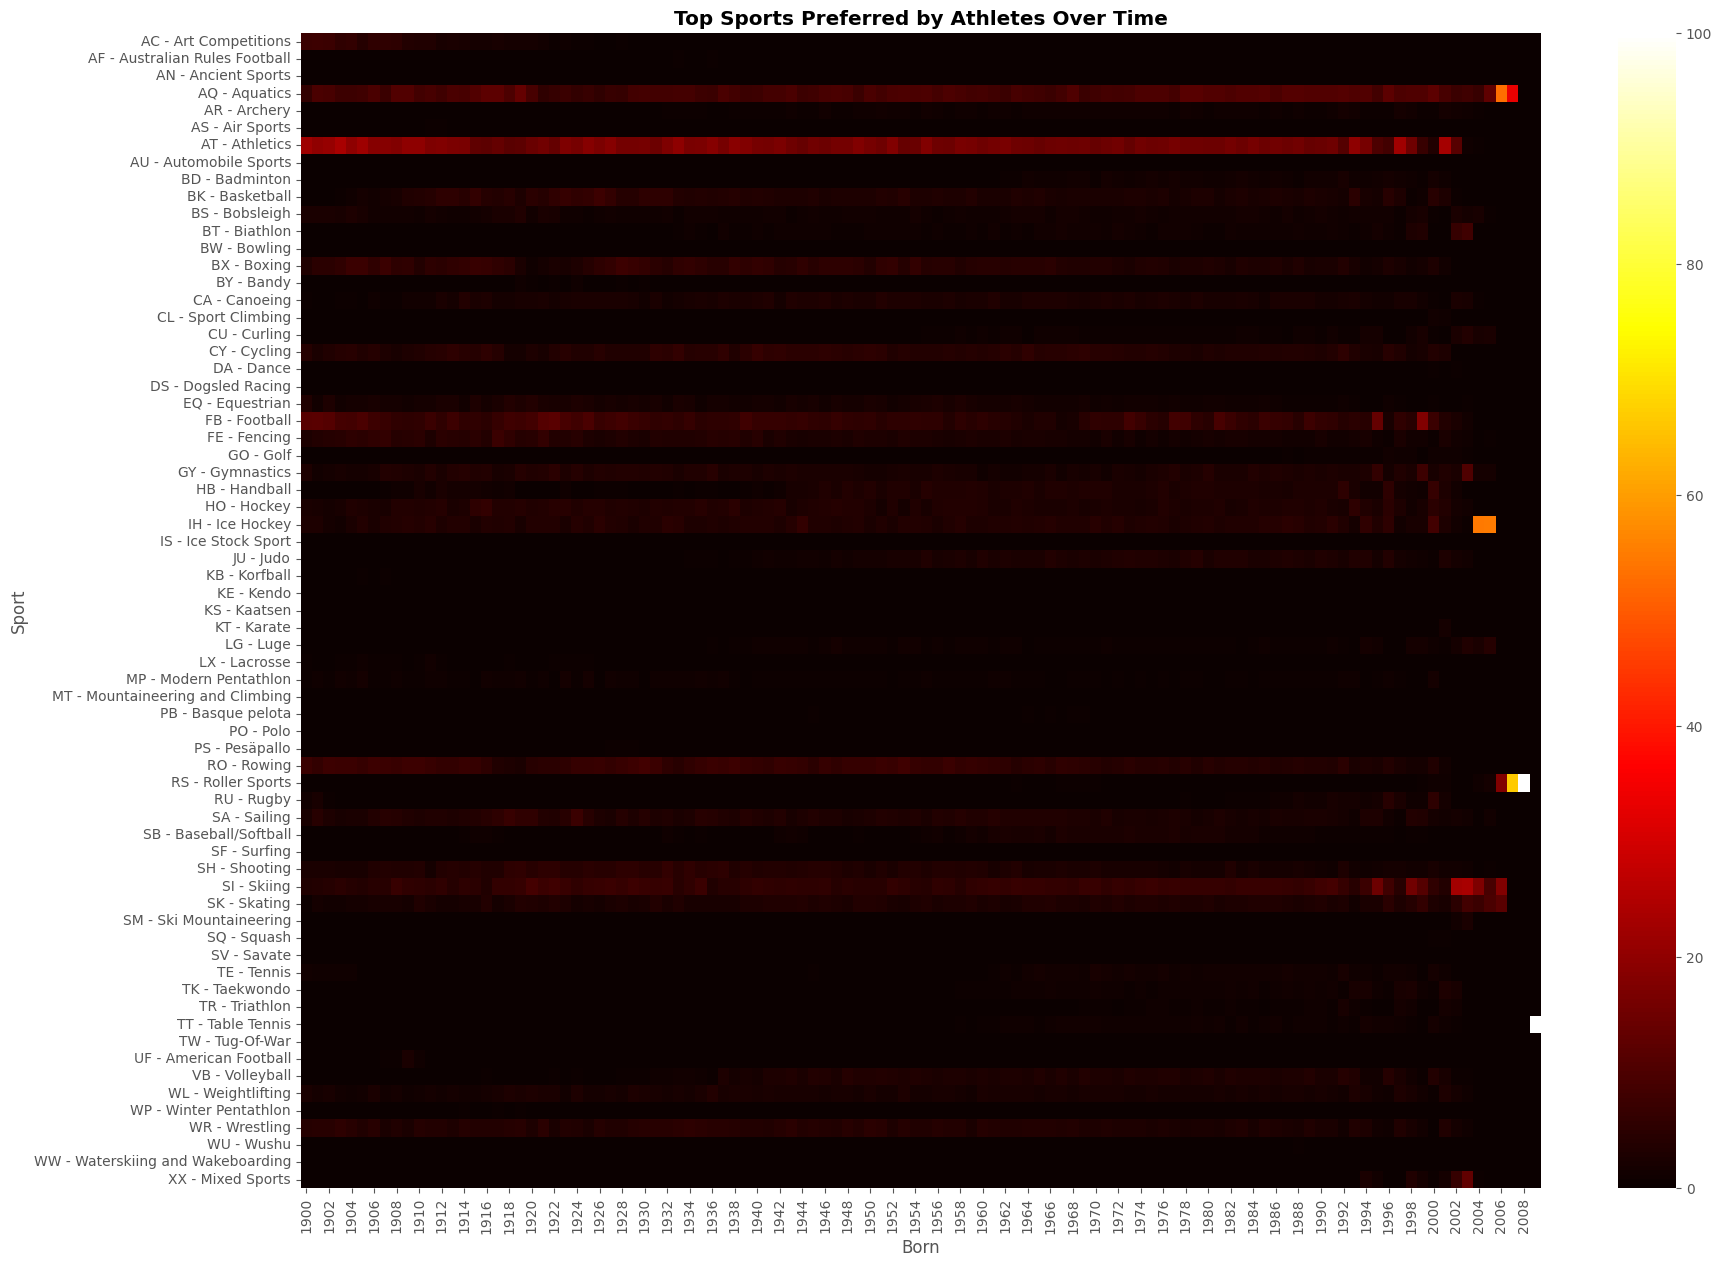

In [16]:
filtered=df[(df['Born'].dt.year>=1900) & (df['Born'].dt.year<=2015)]

matrix=pd.pivot_table(data=filtered, 
               index='Sport',
               columns=filtered['Born'].dt.year,
               values='Full name',
               aggfunc='count'
               ).fillna(0)
matrix = matrix.div(matrix.sum(axis=0), axis=1) * 100


plt.figure(figsize=(20,15))
sns.heatmap(matrix,annot=False,cmap='hot')
plt.title('Top Sports Preferred by Athletes Over Time',fontweight='bold')
plt.show()

In [17]:
df['BMI']=df['Weight (kg)']/(df['Height (cm)']/100)**2

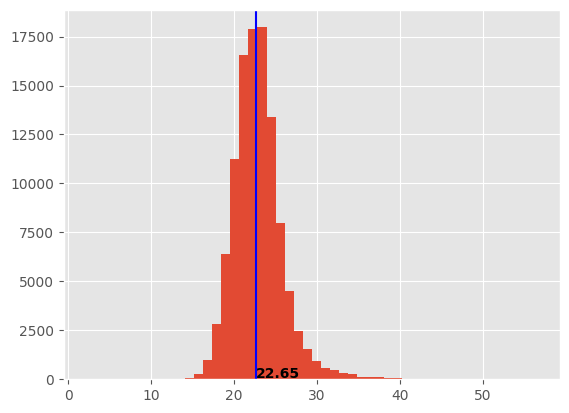

In [18]:
mean=df['BMI'].mean()
std=df['BMI'].std()

filtered=df[(df['BMI'] > mean - 3 * std) & (df['BMI'] < mean + 3 * std)]
median=filtered['BMI'].median()

filtered['BMI'].hist(bins=50)
plt.axvline(median, label='Median',color='blue')
plt.text(median,100,median.round(2),fontweight='bold')
plt.show()

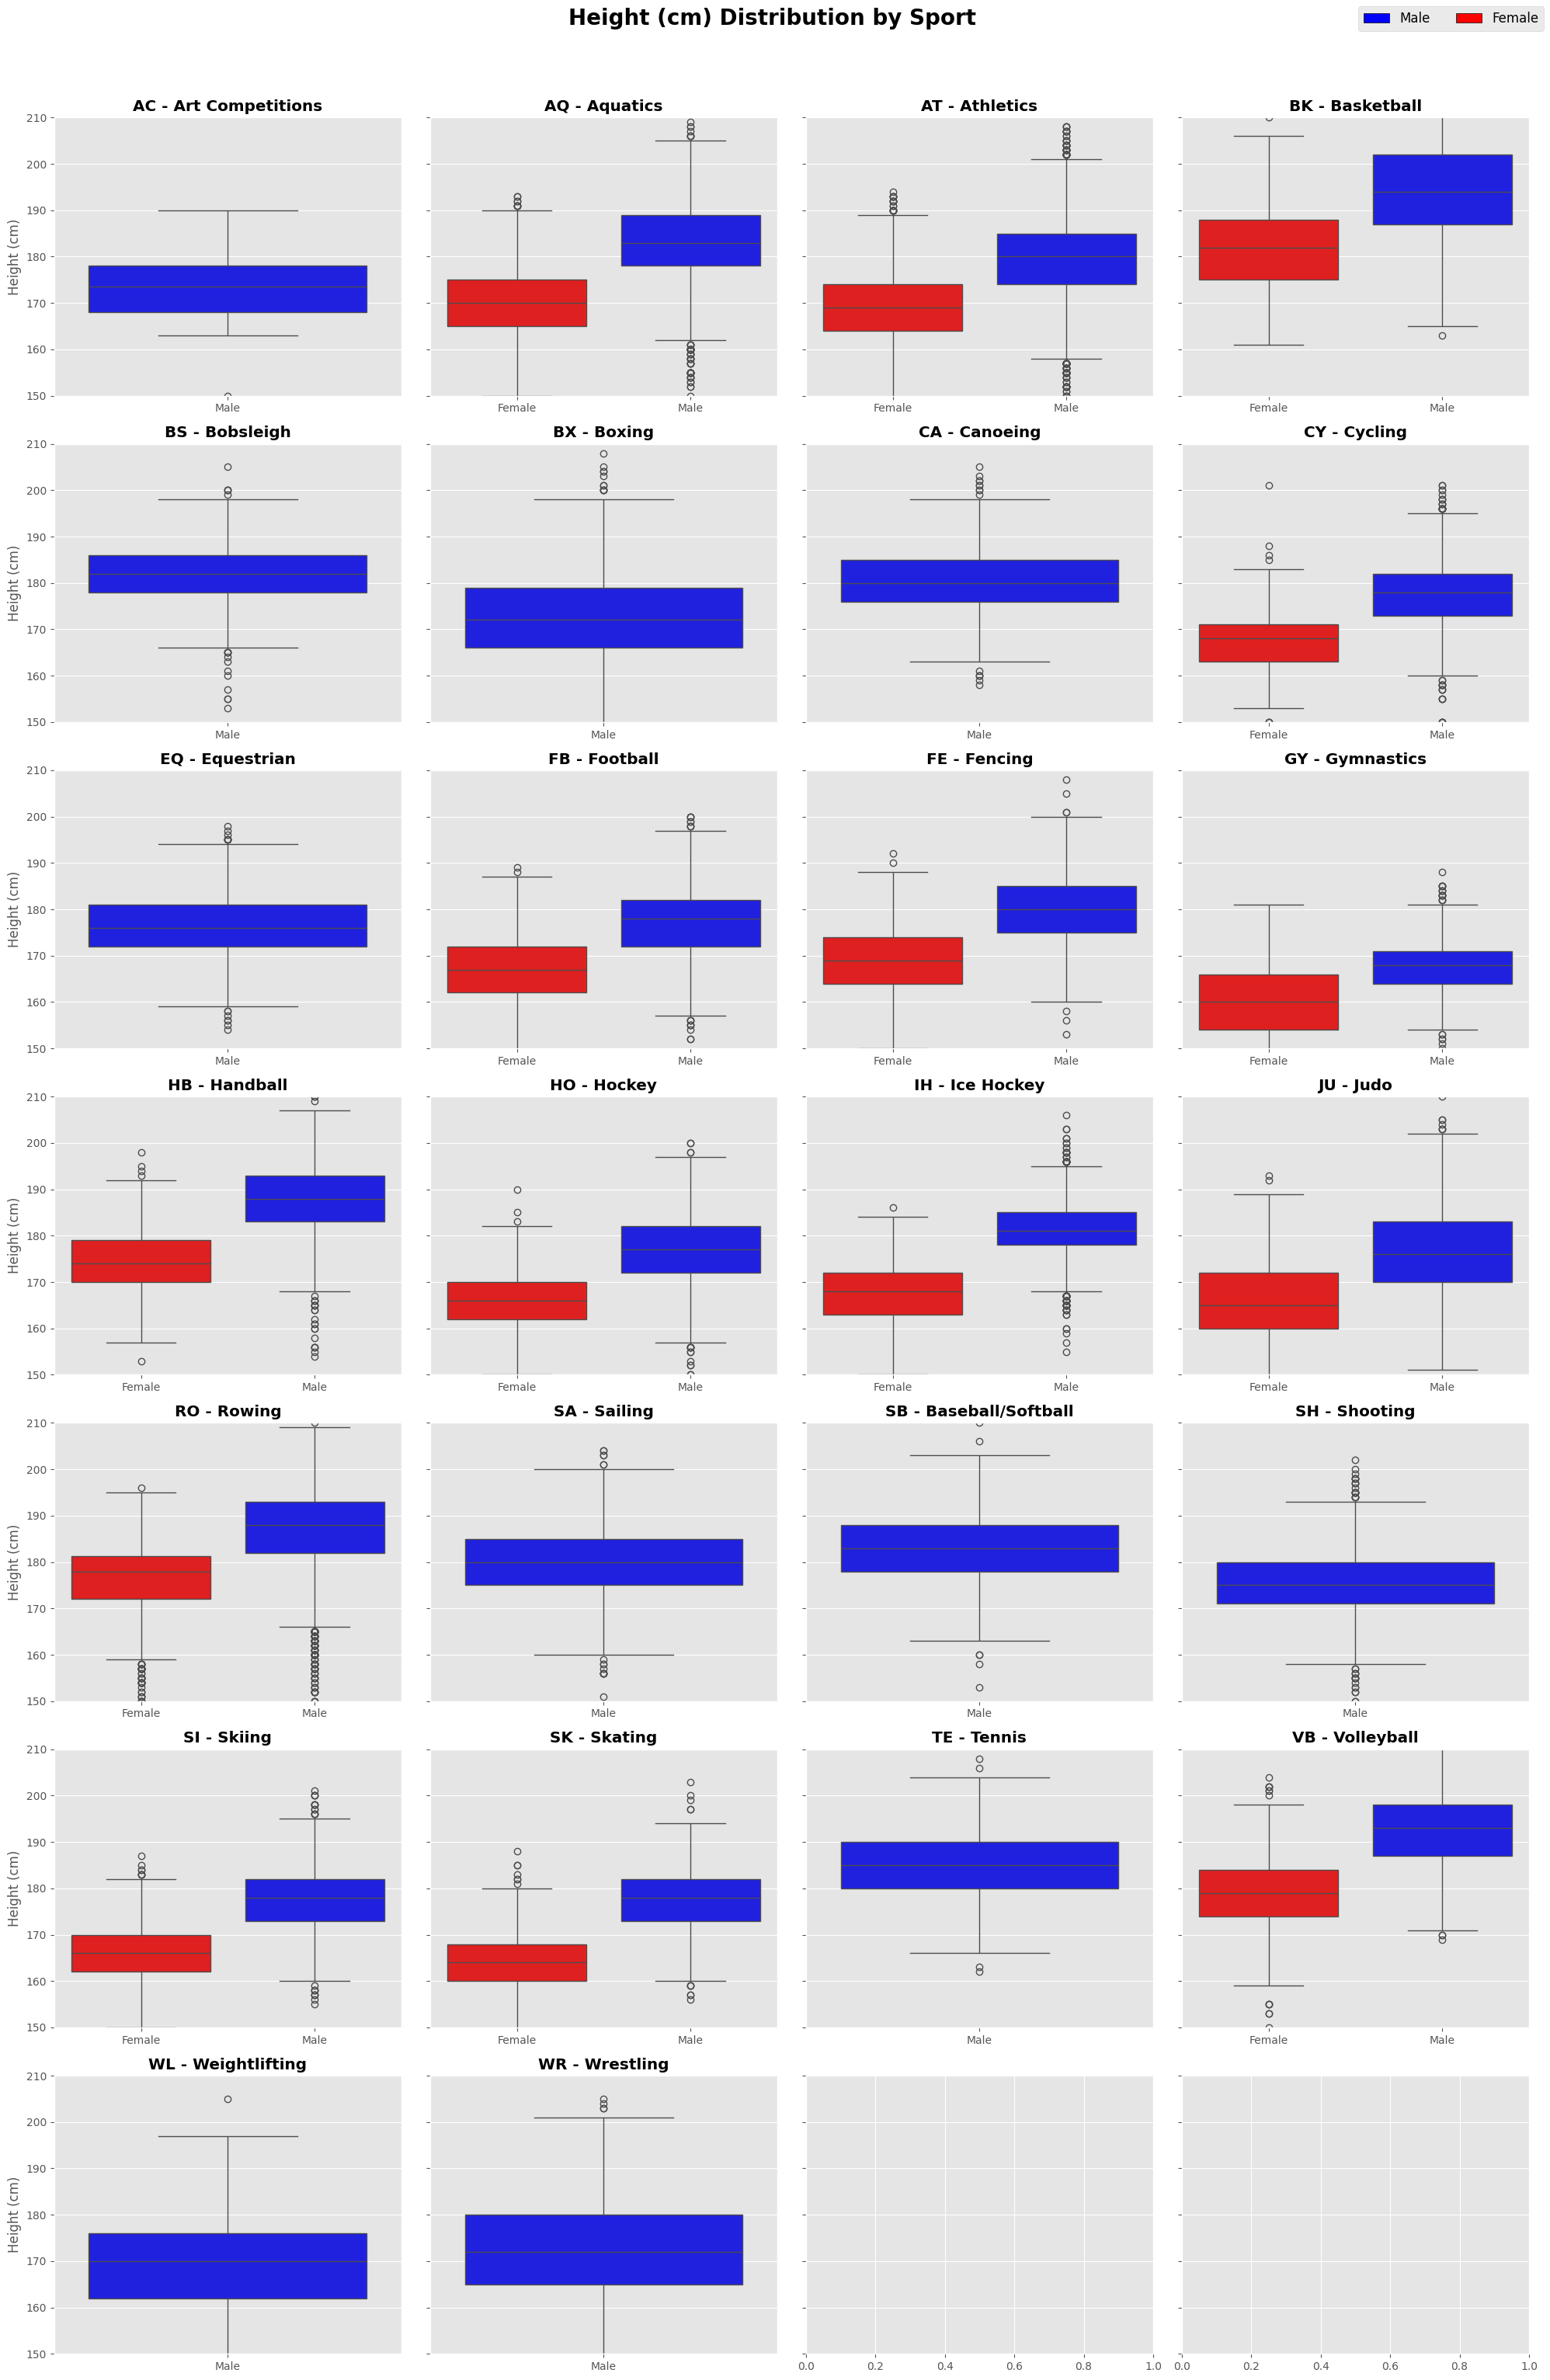

In [41]:
data=df.groupby(['Sport','Sex']).filter(lambda x:x['Full name'].count()>1000)
data=data.sort_values(['Sport','Sex'])

sports=data['Sport'].unique()
fig,axes =plt.subplots(7,4,figsize=(20,30),sharey=True)

for i, (sport, ax) in enumerate(zip(sports, axes.ravel())):
    filtered=data[data['Sport']==sport]

    filtered=data[data['Sport']==sport]
    sns.boxplot(filtered, x='Sex', y='Height (cm)',ax=ax, palette={'Male': 'blue', 'Female': 'red'})
    #sns.stripplot(data=filtered, x='Sex', y='BMI', ax=ax, jitter=True,color='black',alpha=1, size=1)

    ax.set_title(sport,fontweight='bold')
    ax.set_ylim(150,210)
    ax.set_xlabel(None)

    print(i,end='\r')


plt.suptitle('Height (cm) Distribution by Sport', fontweight='bold', size=20, y=1.02)
#plt.subplots_adjust(top=0.9)
plt.tight_layout()

legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='Male'),
    Patch(facecolor='red', edgecolor='black', label='Female')
]

fig.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize='large')
fig.show()